In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
countries = pd.read_csv('../../data/Country-data.csv')
countries

country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu        29.2     46.6    5.25     52.7    2950   
163            Venezuela        17.1     28.5    4.91     17.6   16500   
164              Vietnam        23.3     72.0    6.84     80.2    4490   
165                Yemen        56.3     30.0    5.18     34.4    4480   
166               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  
0         9.44        56.2       5.82    553  
1         4.49        76.3       1.65   4090  
2        16.10        76.5       2.89   4460  
3        22.40        60.1       6.16   3530  
4         1.44        76.8       2.13  12200  
..         ...         ...        ...    ...  
162       2.62        63.0       3.50   2970  
163      45.90        75.4       2.47  13500  
164      12.10        73.1       1.95   1310  
165      23.60        67.5       4.67   1310  
166      14.00        52.0       5.40   1460  

[167 rows x 10 columns]

### EDA

In [6]:
pd.DataFrame({
    "nan": countries.isna().sum(),
    "dtypes": countries.dtypes,
    "nunique": countries.nunique()
})

nan   dtypes  nunique
country       0   object      167
child_mort    0  float64      139
exports       0  float64      147
health        0  float64      147
imports       0  float64      151
income        0    int64      156
inflation     0  float64      156
life_expec    0  float64      127
total_fer     0  float64      138
gdpp          0    int64      157

Todas nuestras variables son de tipo numérico a excepción del nombre del país.

Procedamos con una exploración de correlaciones


<Figure size 640x480 with 0 Axes>

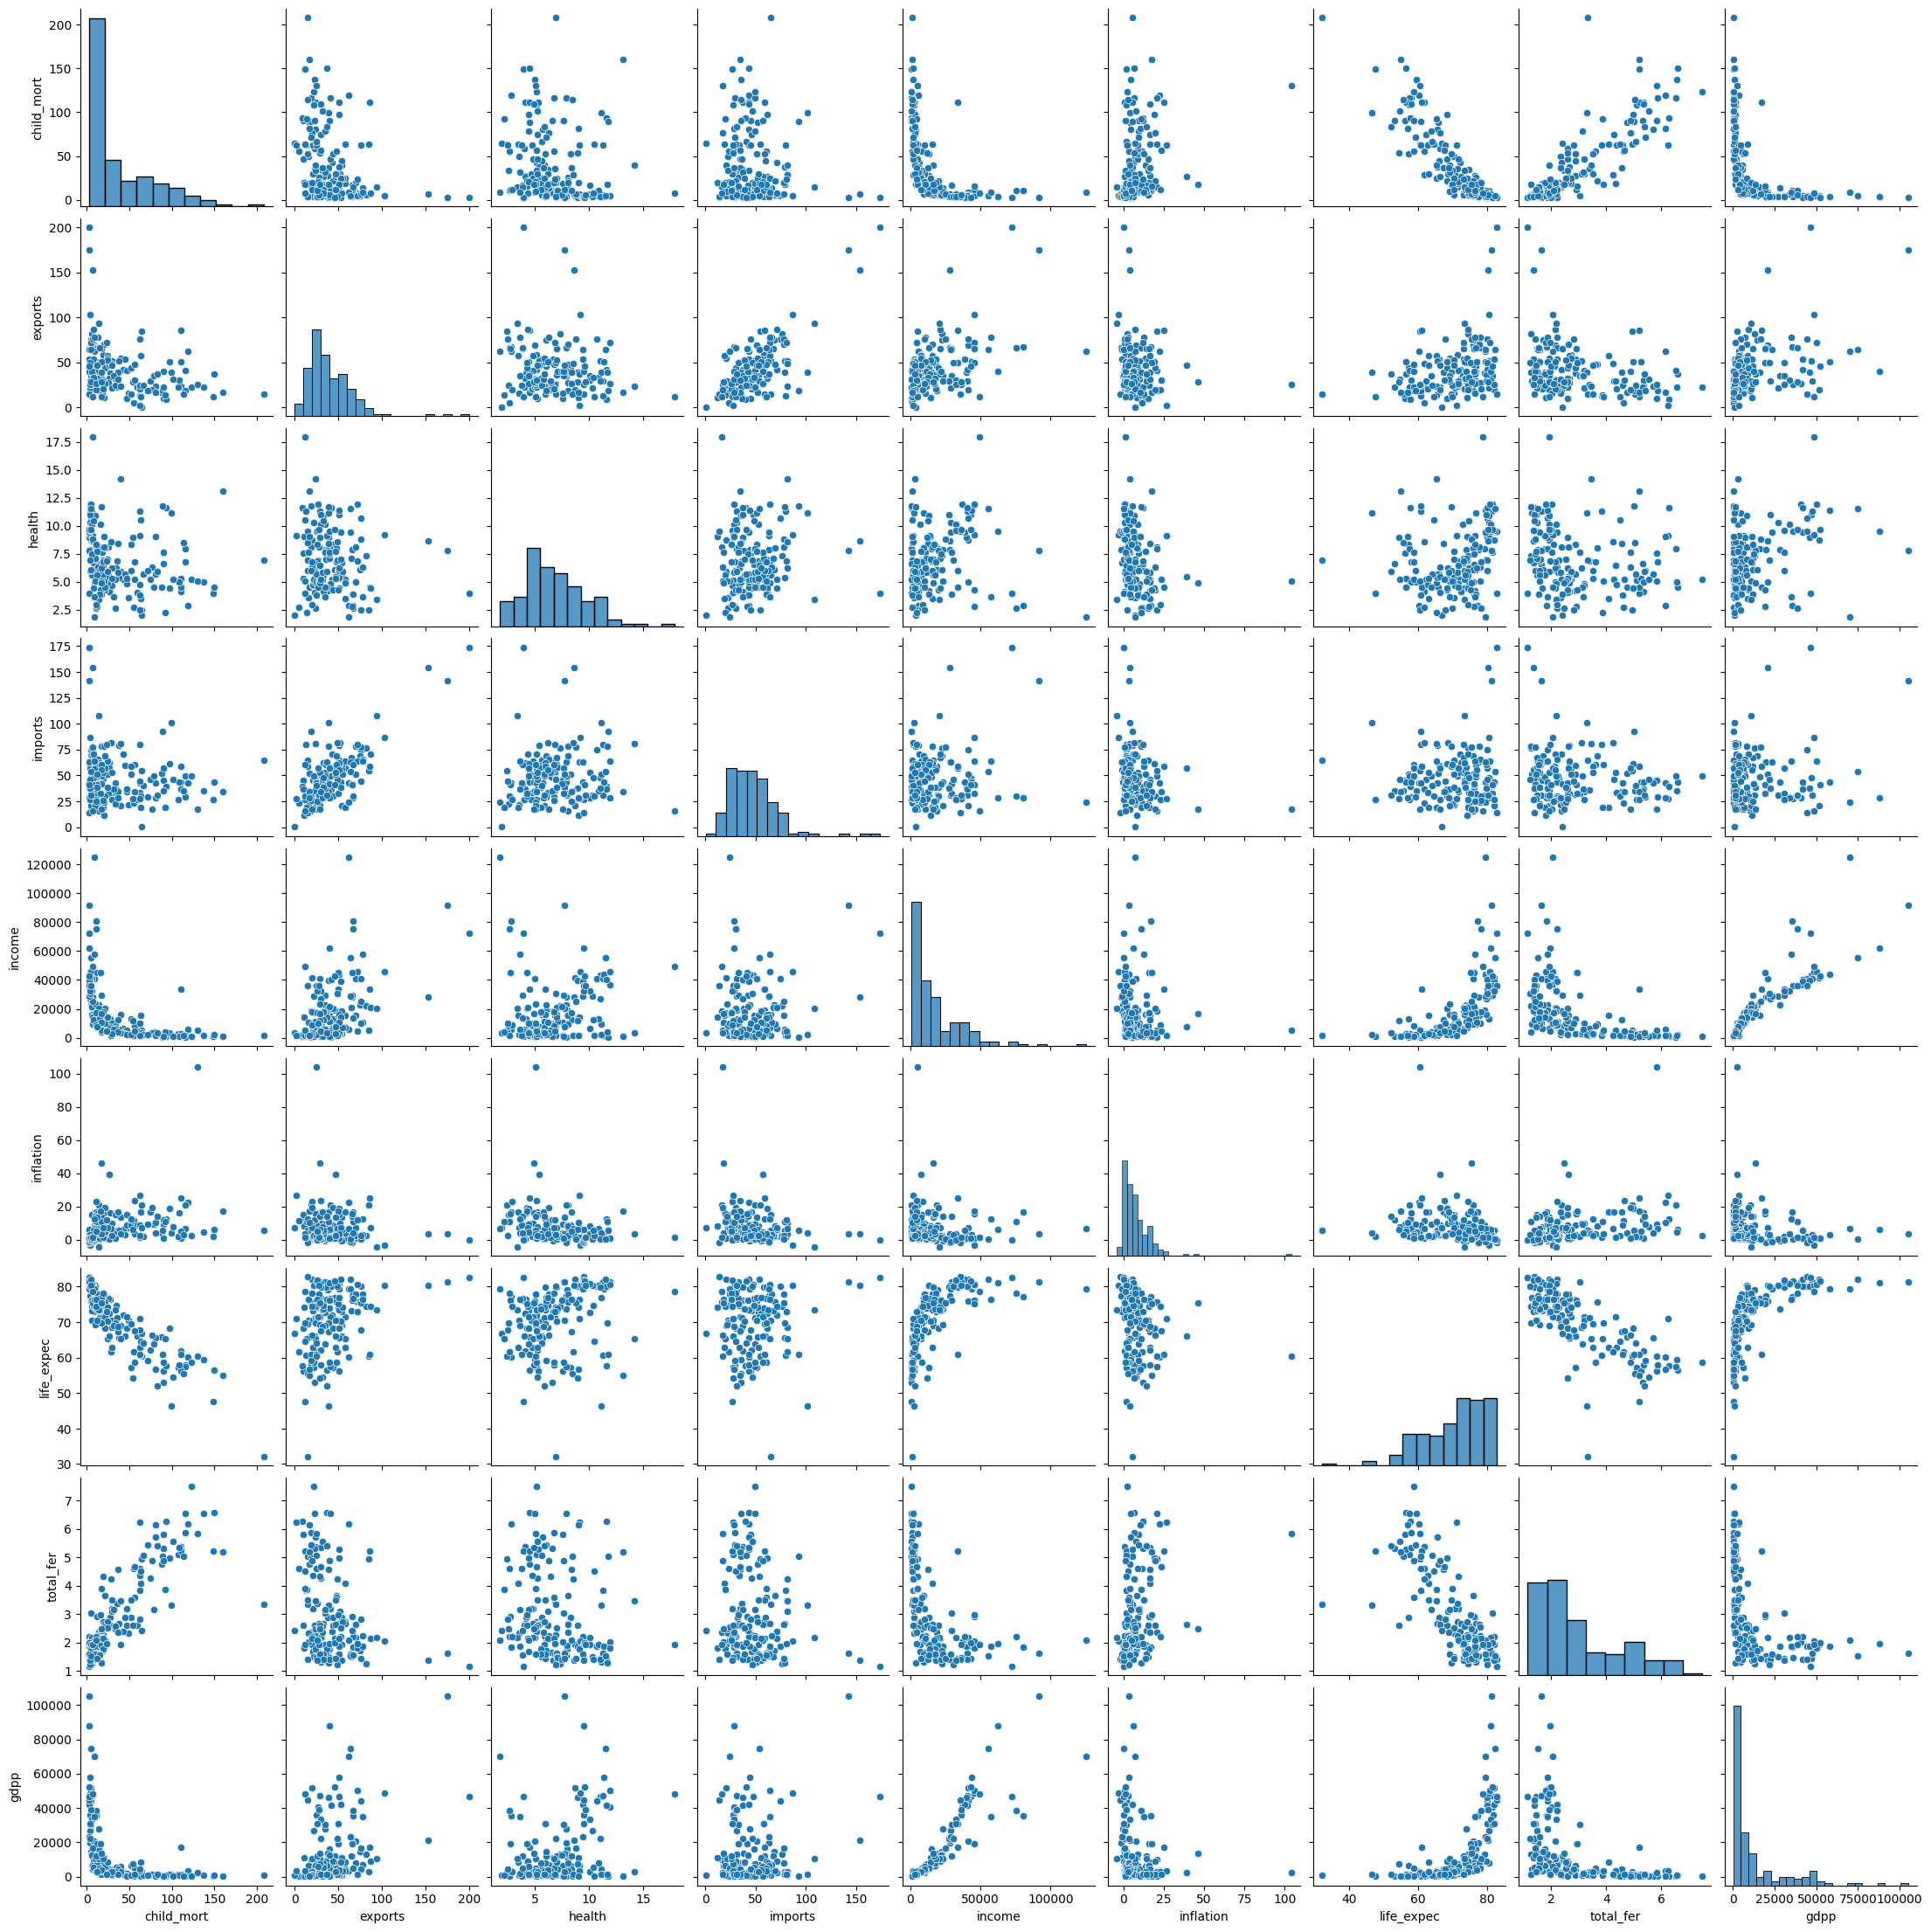

In [7]:
plt.figure()
sns.pairplot(countries)

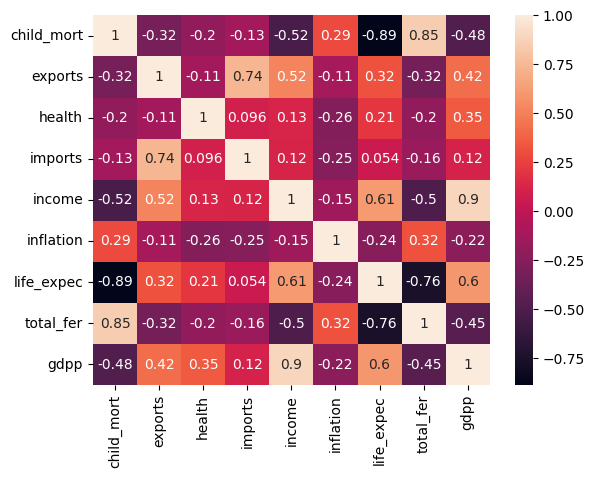

In [10]:
plt.figure()
sns.heatmap(countries.drop(columns=["country"]).corr(), annot=True)
plt.show()


Ahora busquemos outliers en función de definir un método de escalamiento adecuado

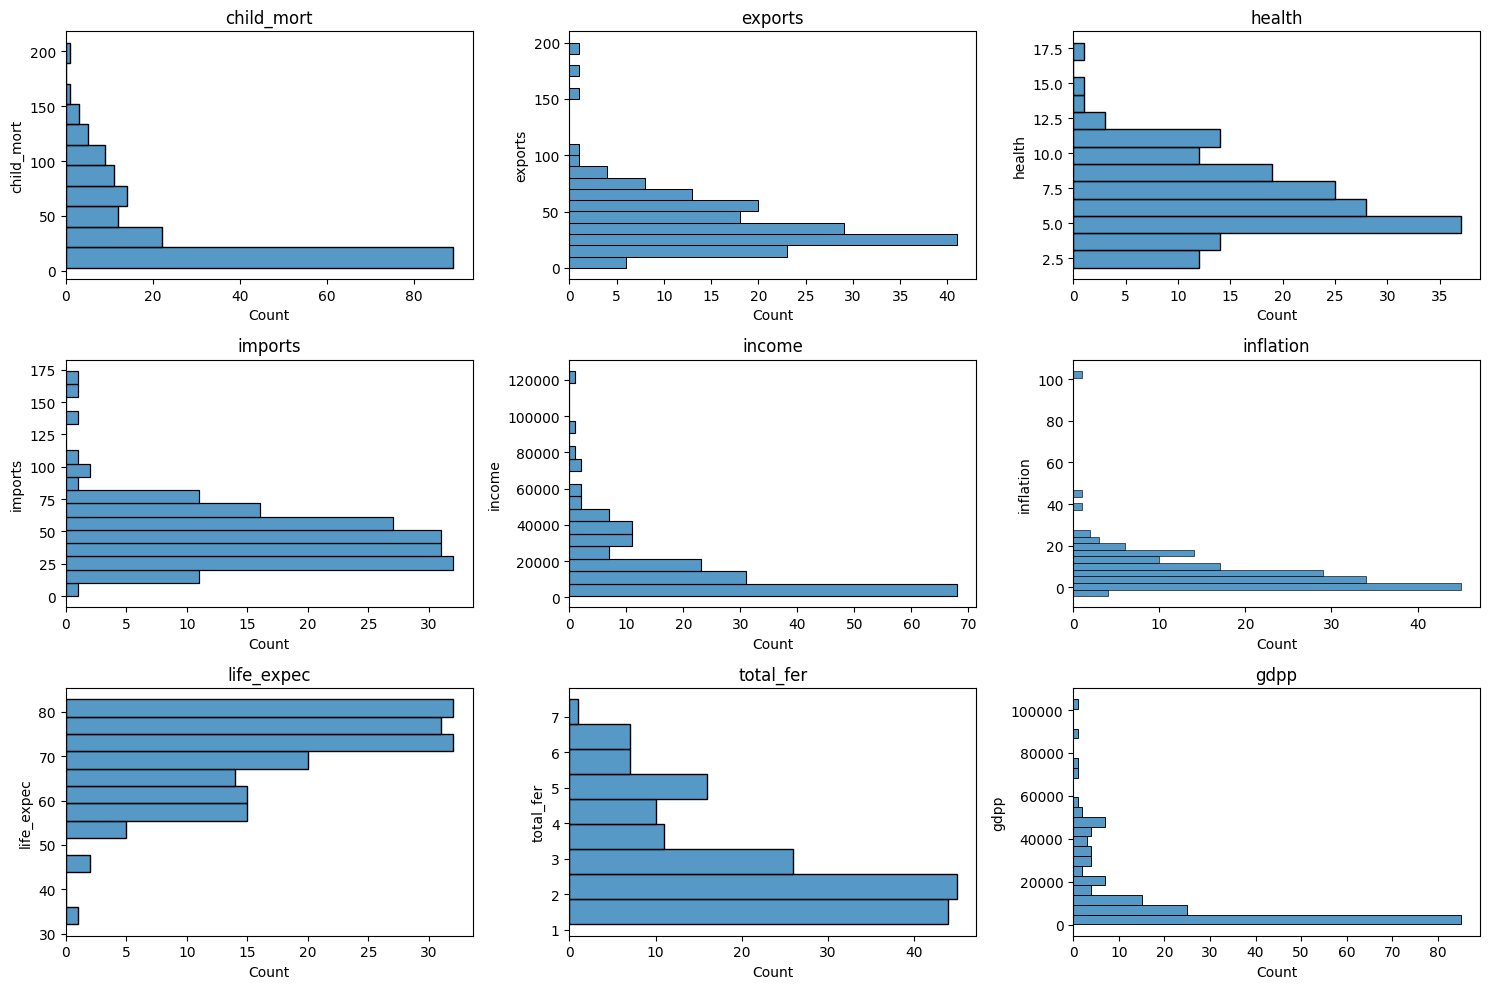

In [33]:
plt.figure(figsize=(15, 10))

num_columns = countries.drop(columns=["country"]).shape[1]
for i, column in enumerate(countries.drop(columns=["country"]).columns):
    plt.subplot((num_columns + 1) // 3, 3, i + 1) 
    sns.histplot(data=countries, y=column)
    plt.title(column)

plt.tight_layout()
plt.show()

Vemos que para la mayoría de variables existen outliers, sin embargo, las variables para las que los outliers están exageradamente alejados de la media son pocas (gdpp, income, inflation). Lo ideal sería utilizar distintos scalers como RobustScaler para estas últimas y un StandardScaler para las demás. Por ahora, por simplicidad, se utilizará el StandardScaler.

In [79]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

countries_scaled = countries.copy()
countries_scaled[countries.drop(columns=["country"]).columns] = scaler.fit_transform(countries.drop(columns=["country"]))
countries_scaled

country  child_mort   exports    health   imports    income  \
0            Afghanistan    1.291532 -1.138280  0.279088 -0.082455 -0.808245   
1                Albania   -0.538949 -0.479658 -0.097016  0.070837 -0.375369   
2                Algeria   -0.272833 -0.099122 -0.966073 -0.641762 -0.220844   
3                 Angola    2.007808  0.775381 -1.448071 -0.165315 -0.585043   
4    Antigua and Barbuda   -0.695634  0.160668 -0.286894  0.497568  0.101732   
..                   ...         ...       ...       ...       ...       ...   
162              Vanuatu   -0.225578  0.200917 -0.571711  0.240700 -0.738527   
163            Venezuela   -0.526514 -0.461363 -0.695862 -1.213499 -0.033542   
164              Vietnam   -0.372315  1.130305  0.008877  1.380030 -0.658404   
165                Yemen    0.448417 -0.406478 -0.597272 -0.517472 -0.658924   
166               Zambia    1.114951 -0.150348 -0.338015 -0.662477 -0.721358   

     inflation  life_expec  total_fer      gdpp  
0     0.157336   -1.619092   1.902882 -0.679180  
1    -0.312347    0.647866  -0.859973 -0.485623  
2     0.789274    0.670423  -0.038404 -0.465376  
3     1.387054   -1.179234   2.128151 -0.516268  
4    -0.601749    0.704258  -0.541946 -0.041817  
..         ...         ...        ...       ...  
162  -0.489784   -0.852161   0.365754 -0.546913  
163   3.616865    0.546361  -0.316678  0.029323  
164   0.409732    0.286958  -0.661206 -0.637754  
165   1.500916   -0.344633   1.140944 -0.637754  
166   0.590015   -2.092785   1.624609 -0.629546  

[167 rows x 10 columns]

Listo, tenemos bastantes variables numéricas para aplicar clusterización y vimos que existe una fuerte correlación entre algunas de las variables por lo que buscaremos aplicar reducción de dimensionalidad con PCA antes de realizar la clusterización.

In [80]:
from sklearn.decomposition import PCA

countries_pca = countries_scaled.copy()

pca = PCA(n_components=4, random_state=42)
pca.fit(countries_scaled.drop(columns=["country"]))
countries_pca = pca.transform(countries_scaled.drop(columns=["country"]))


countries_pca = pd.DataFrame(countries_pca, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])
countries_pca, pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()

(          PC1       PC2       PC3       PC4
 0   -2.913025  0.095621 -0.718118  1.005255
 1    0.429911 -0.588156 -0.333486 -1.161059
 2   -0.285225 -0.455174  1.221505 -0.868115
 3   -2.932423  1.695555  1.525044  0.839625
 4    1.033576  0.136659 -0.225721 -0.847063
 ..        ...       ...       ...       ...
 162 -0.820631  0.639570 -0.389923 -0.706595
 163 -0.551036 -1.233886  3.101350 -0.115311
 164  0.498524  1.390744 -0.238526 -1.074098
 165 -1.887451 -0.109453  1.109752  0.056257
 166 -2.864064  0.485998  0.223167  0.816364
 
 [167 rows x 4 columns],
 array([0.4595174 , 0.17181626, 0.13004259, 0.11053162]),
 0.8719078614023911)

Con 4 componentes principales logramos conservar el 90% de la varianza de los datos. Sobre estas aplicaremos distintos métodos de clusterización.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_clusters = 10
inertia = []
silhouette_scores = []

for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(countries_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(countries_pca, kmeans.labels_))

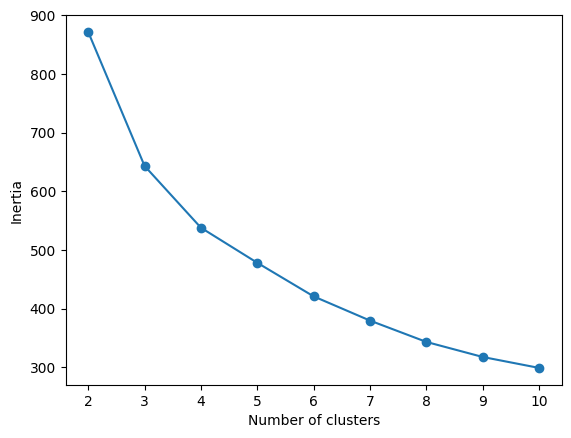

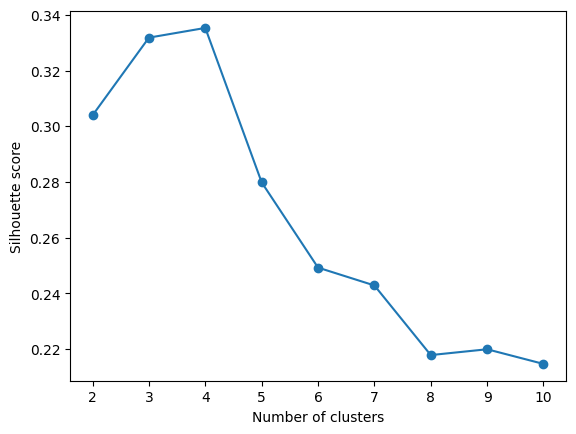

In [82]:
plt.figure()
plt.plot(range(2, max_clusters + 1), inertia, "o-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(range(2, max_clusters + 1), silhouette_scores, "o-")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()


Existe coincidencia en que 4 es el mejor número de clusters.

Hay que tener en cuenta que tanto inertia como silhouette score son medidas que funcionan muy bien con clusters de tipo esférico. En este caso, al tener muchas más de 3 variables, no podemos ver qué tan "clumpy" los clusters son. Hay que tener cuidado. Que la reducción en inercia sea tan baja y que los score silueta sean tan bajos ya nos dan a entender que es las 4 dimensiones que estamos trabajando los clusters no tienden a esfericidad.

Para ilustrar lo anterior, haremos un pca de 3 y graficaremos en 3d para ver la distribución de los paises.

The explained variance ratio is 0.7613762433466719


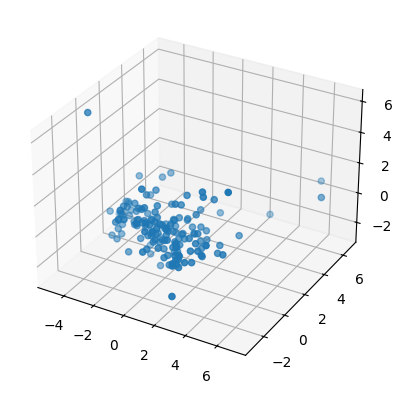

In [107]:
pca_3 = PCA(n_components=3, random_state=42)

countries_pca_3 = pca_3.fit_transform(countries_scaled.drop(columns=["country"]))
countries_pca_3 = pd.DataFrame(countries_pca_3, columns=[f"PC{i}" for i in range(1, pca_3.n_components_ + 1)])
print(f"The explained variance ratio is {pca_3.explained_variance_ratio_.sum()}")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(countries_pca_3["PC1"], countries_pca_3["PC2"], countries_pca_3["PC3"])
plt.show()

Nótese cómo en 3 dimensiones, los datos no parecen aglomerarse de forma esférica. Esto junto con lo mencionado anteriormente sufiere que ni el k-means ni las métricas son las más apropiadas.

In [108]:
best_k_means = KMeans(n_clusters=4, random_state=42)
best_k_means.fit(countries_pca)
countries["cluster"] = best_k_means.labels_

In [109]:
countries["cluster"].value_counts()

cluster
0    85
2    47
3    27
1     8
Name: count, dtype: int64

### Ahora con hierarchical clustering

In [112]:
countries_pca

PC1       PC2       PC3       PC4
0   -2.913025  0.095621 -0.718118  1.005255
1    0.429911 -0.588156 -0.333486 -1.161059
2   -0.285225 -0.455174  1.221505 -0.868115
3   -2.932423  1.695555  1.525044  0.839625
4    1.033576  0.136659 -0.225721 -0.847063
..        ...       ...       ...       ...
162 -0.820631  0.639570 -0.389923 -0.706595
163 -0.551036 -1.233886  3.101350 -0.115311
164  0.498524  1.390744 -0.238526 -1.074098
165 -1.887451 -0.109453  1.109752  0.056257
166 -2.864064  0.485998  0.223167  0.816364

[167 rows x 4 columns]

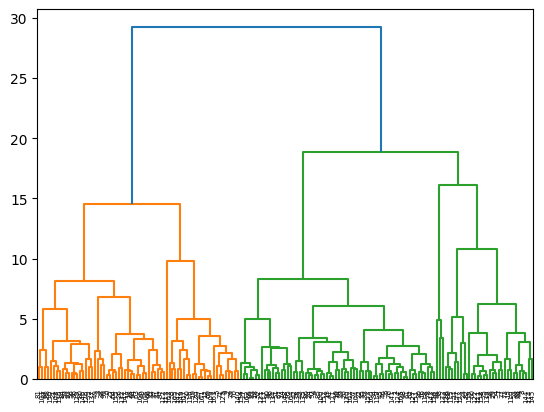

In [110]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(countries_pca, method="ward")
plt.figure()
dendrogram(Z)
plt.show()

Al trazar una línea horizontal que divida el número de clusters, puede verse que pasamos de 2 a 3 y luego a 5 clusters. Exploremos k=3.

In [111]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)
agg.fit(countries_pca)
countries["hc_cluster"] = agg.labels_

silhouette_score(countries_pca, agg.labels_)

0.3070110704080524

Nuevamente vemos cómo el silhouette score es relativamente pequeño. Insisto en que esta métrica no es la adecuada para medir a este dataset.
¿Cuál podría ser una buena alternativa?

For datasets where data doesn't group into spherical or "clumpy" clusters, and where traditional metrics like the elbow method with inertia or silhouette scores are not effective, you might consider the following alternative metrics and methods for evaluating the quality of clustering:

Davies-Bouldin Index: This index signifies the average 'similarity' between clusters, where similarity is a measure that compares the distance between clusters with the size of the clusters themselves. A lower Davies-Bouldin Index indicates better clustering.

Calinski-Harabasz Index (Variance Ratio Criterion): This metric evaluates clustering by computing the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters. Higher values generally indicate better clustering that has tighter clusters.

Gap Statistic: The Gap Statistic compares the total within intra-cluster variation for different values of k with their expected values under null reference distribution of the data. The optimal number of clusters is the value of k at which the gap statistic is maximized.

Mutual Information Based Scores: Measures like Adjusted Mutual Information (AMI) or Normalized Mutual Information (NMI) compare the agreement of the true cluster assignments with the predicted ones, while adjusting or normalizing for chance. These are useful when the true cluster labels are known.

Clustering Stability: Assessing the stability of the clustering results by applying the clustering algorithm after perturbing the dataset can provide insights into the reliability of the chosen clustering approach.

Silhouette Analysis with Non-Euclidean Distance Metrics: If you haven't already, consider using silhouette analysis with different distance metrics that might be more appropriate for your data, such as cosine similarity for text data or Manhattan (L1) distance for Manhattan-like structures.

### Ahora con DBSCAN

In [119]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(countries_pca)
distances, indices = neigh.kneighbors(countries_pca)

Una idea común para encontrar el valor óptimo para el eps es tomar, para cada punto, cuál es la distancia a su vecino más cercano, y graficar en orden ascendente para conocer cuál es esa distancia "media" apropiada para generalizar la búsqueda de vecinos.

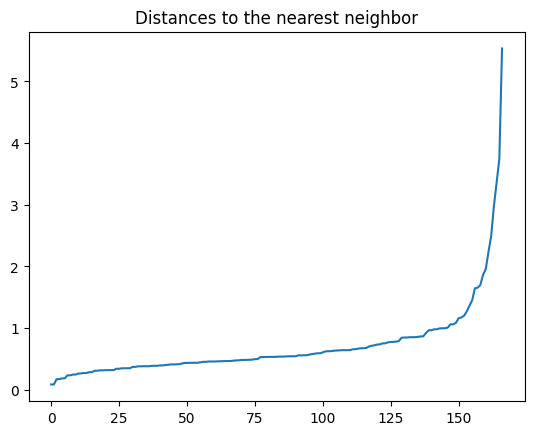

In [124]:
plt.title("Distances to the nearest neighbor")
plt.plot(np.sort(distances[:, 1]))
plt.show()

Esto nos sugiere tomar un eps de entre 0.5 y 2.

In [125]:
from sklearn.cluster import DBSCAN

eps_values = np.linspace(0.5, 2, 100)
min_samples_values = range(2, 10)
silhouette_scores = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(countries_pca)
        if len(np.unique(dbscan.labels_)) > 1:
            silhouette_scores.append((eps, min_samples, silhouette_score(countries_pca, dbscan.labels_)))

In [126]:
#best hyperparameters
best_eps, best_min_samples, best_score = max(silhouette_scores, key=lambda x: x[2])
best_eps, best_min_samples, best_score

(1.9696969696969697, 2, 0.5559794381317748)

In [132]:
best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)

best_dbscan.fit(countries_pca)
countries["dbscan_cluster"] = best_dbscan.labels_

In [135]:
#encuentra un solo cluster
countries["dbscan_cluster"].value_counts()

dbscan_cluster
 0    161
-1      6
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

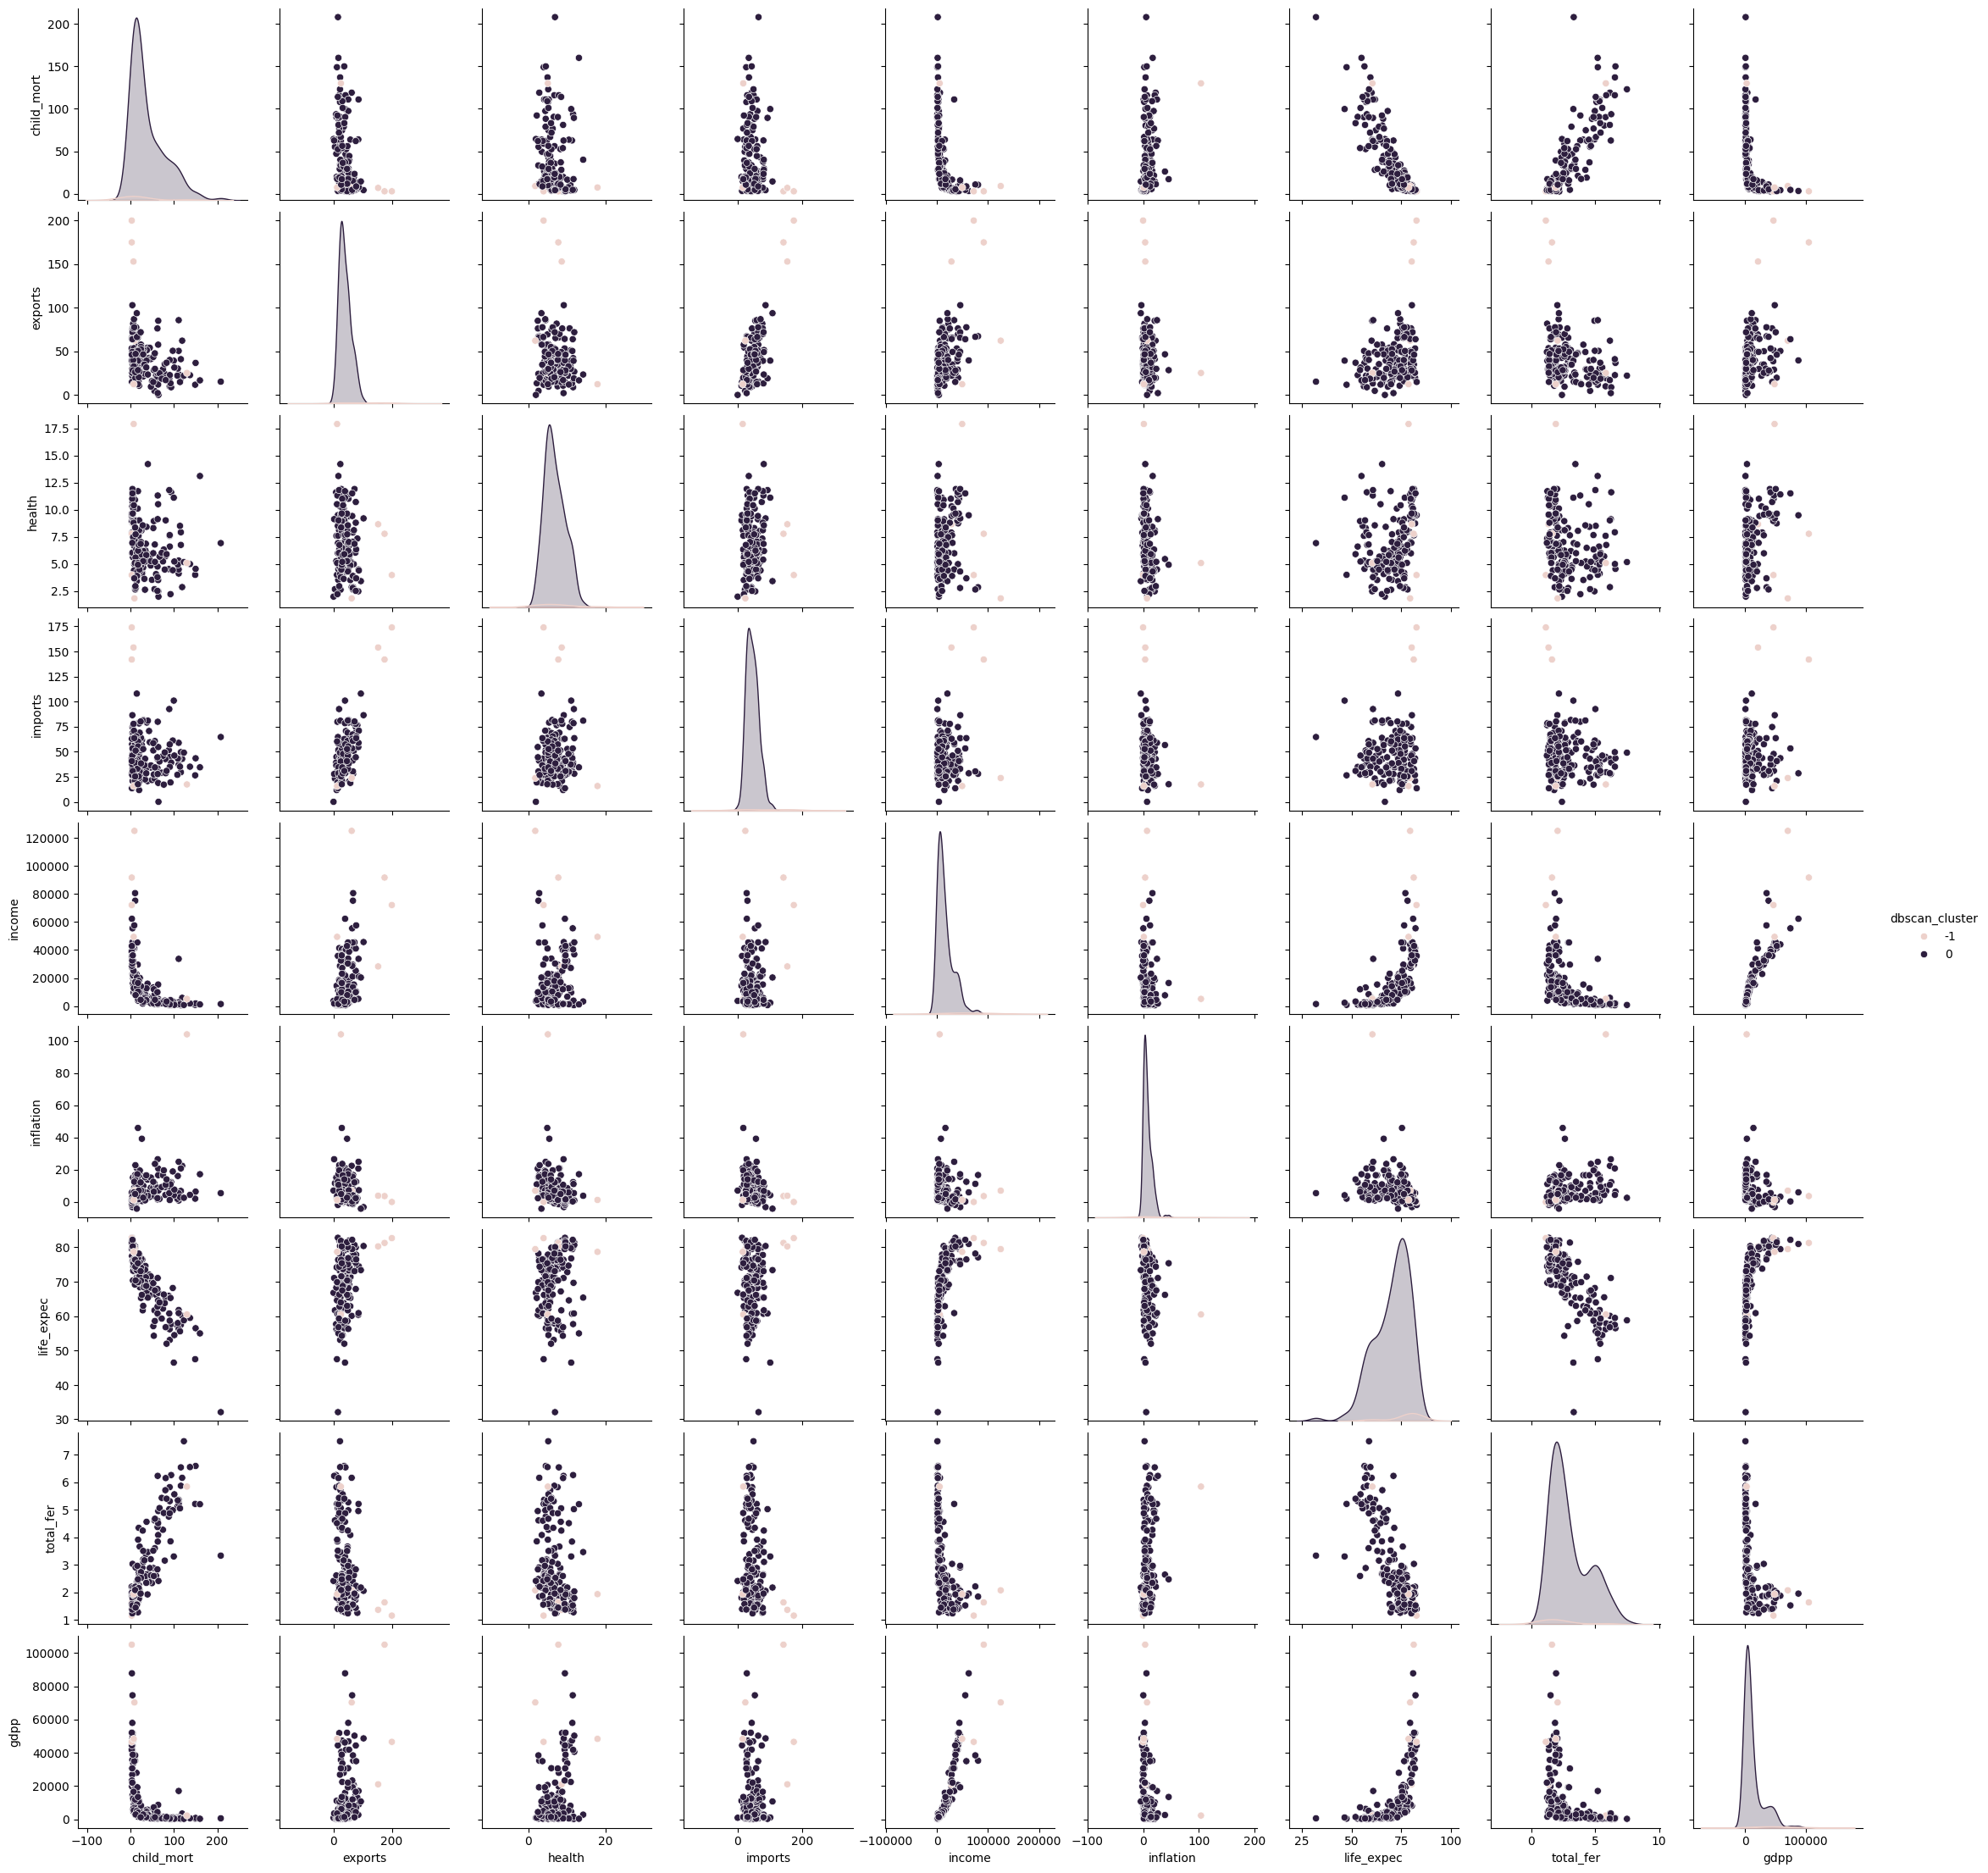

In [136]:
plt.figure()
sns.pairplot(countries.drop(columns=["cluster", "hc_cluster"]), hue="dbscan_cluster")

<Figure size 640x480 with 0 Axes>

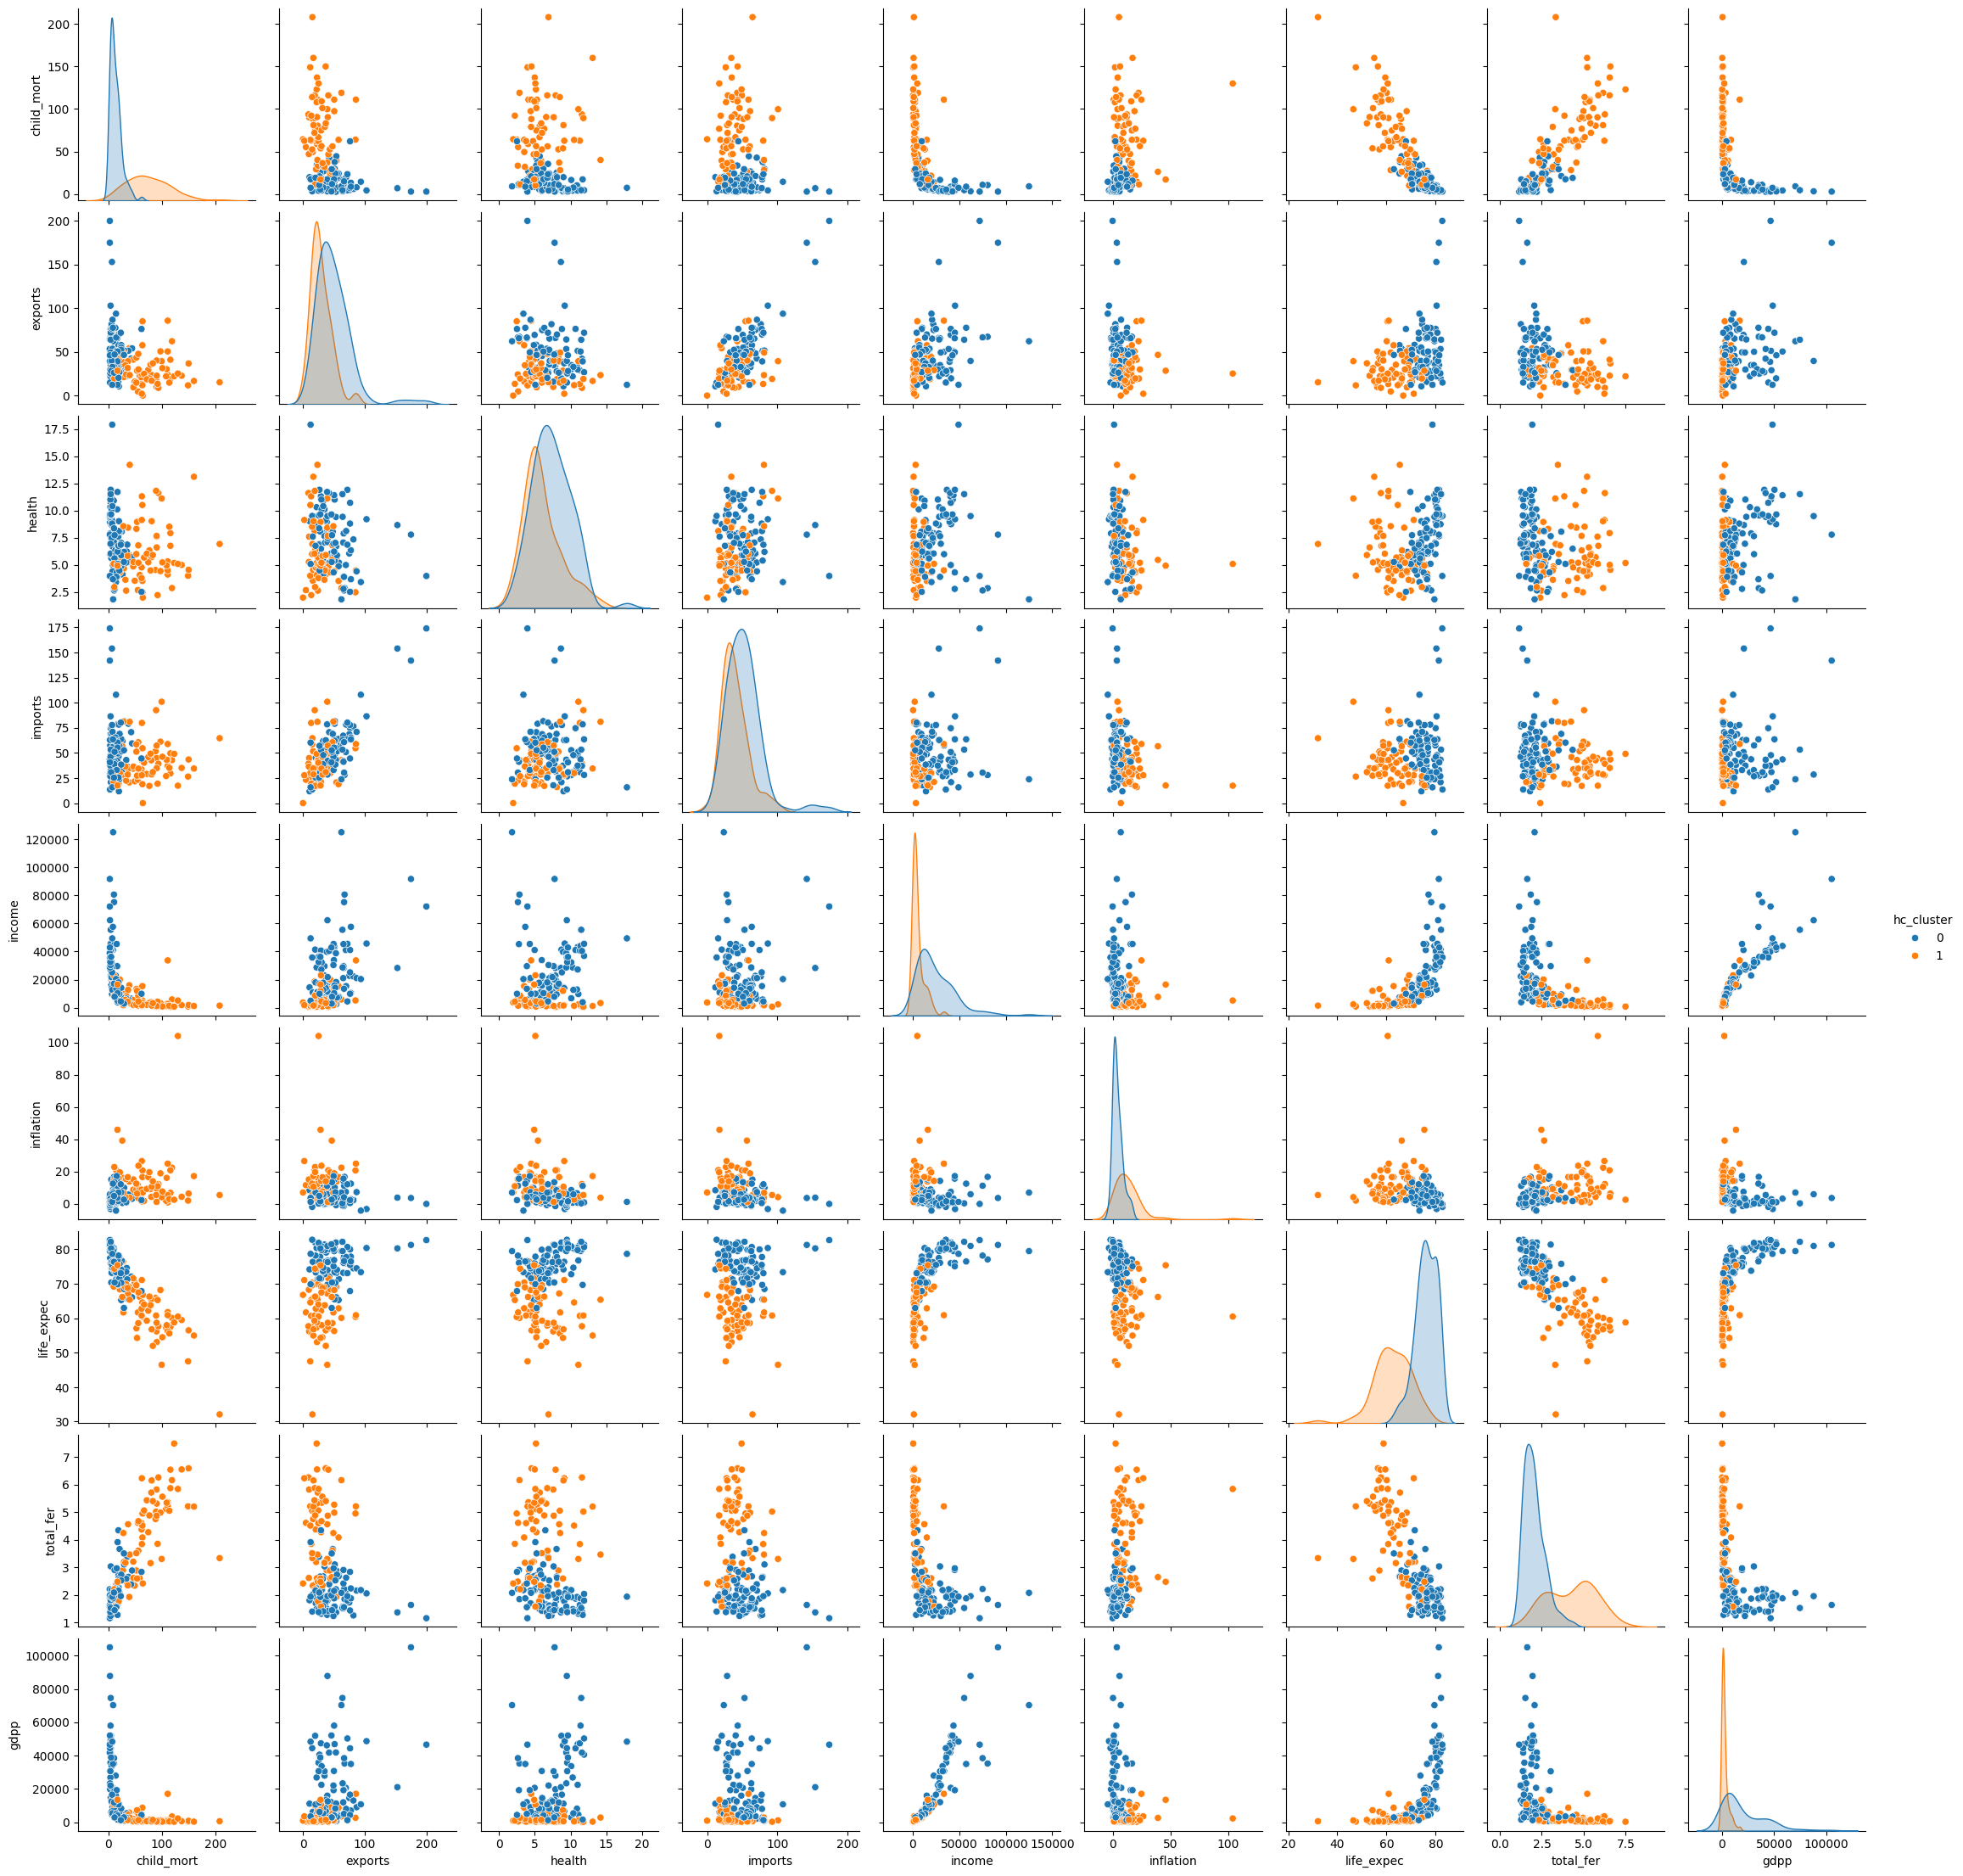

In [137]:
plt.figure()
sns.pairplot(countries.drop(columns=["cluster", "dbscan_cluster"]), hue="hc_cluster")

<Figure size 640x480 with 0 Axes>

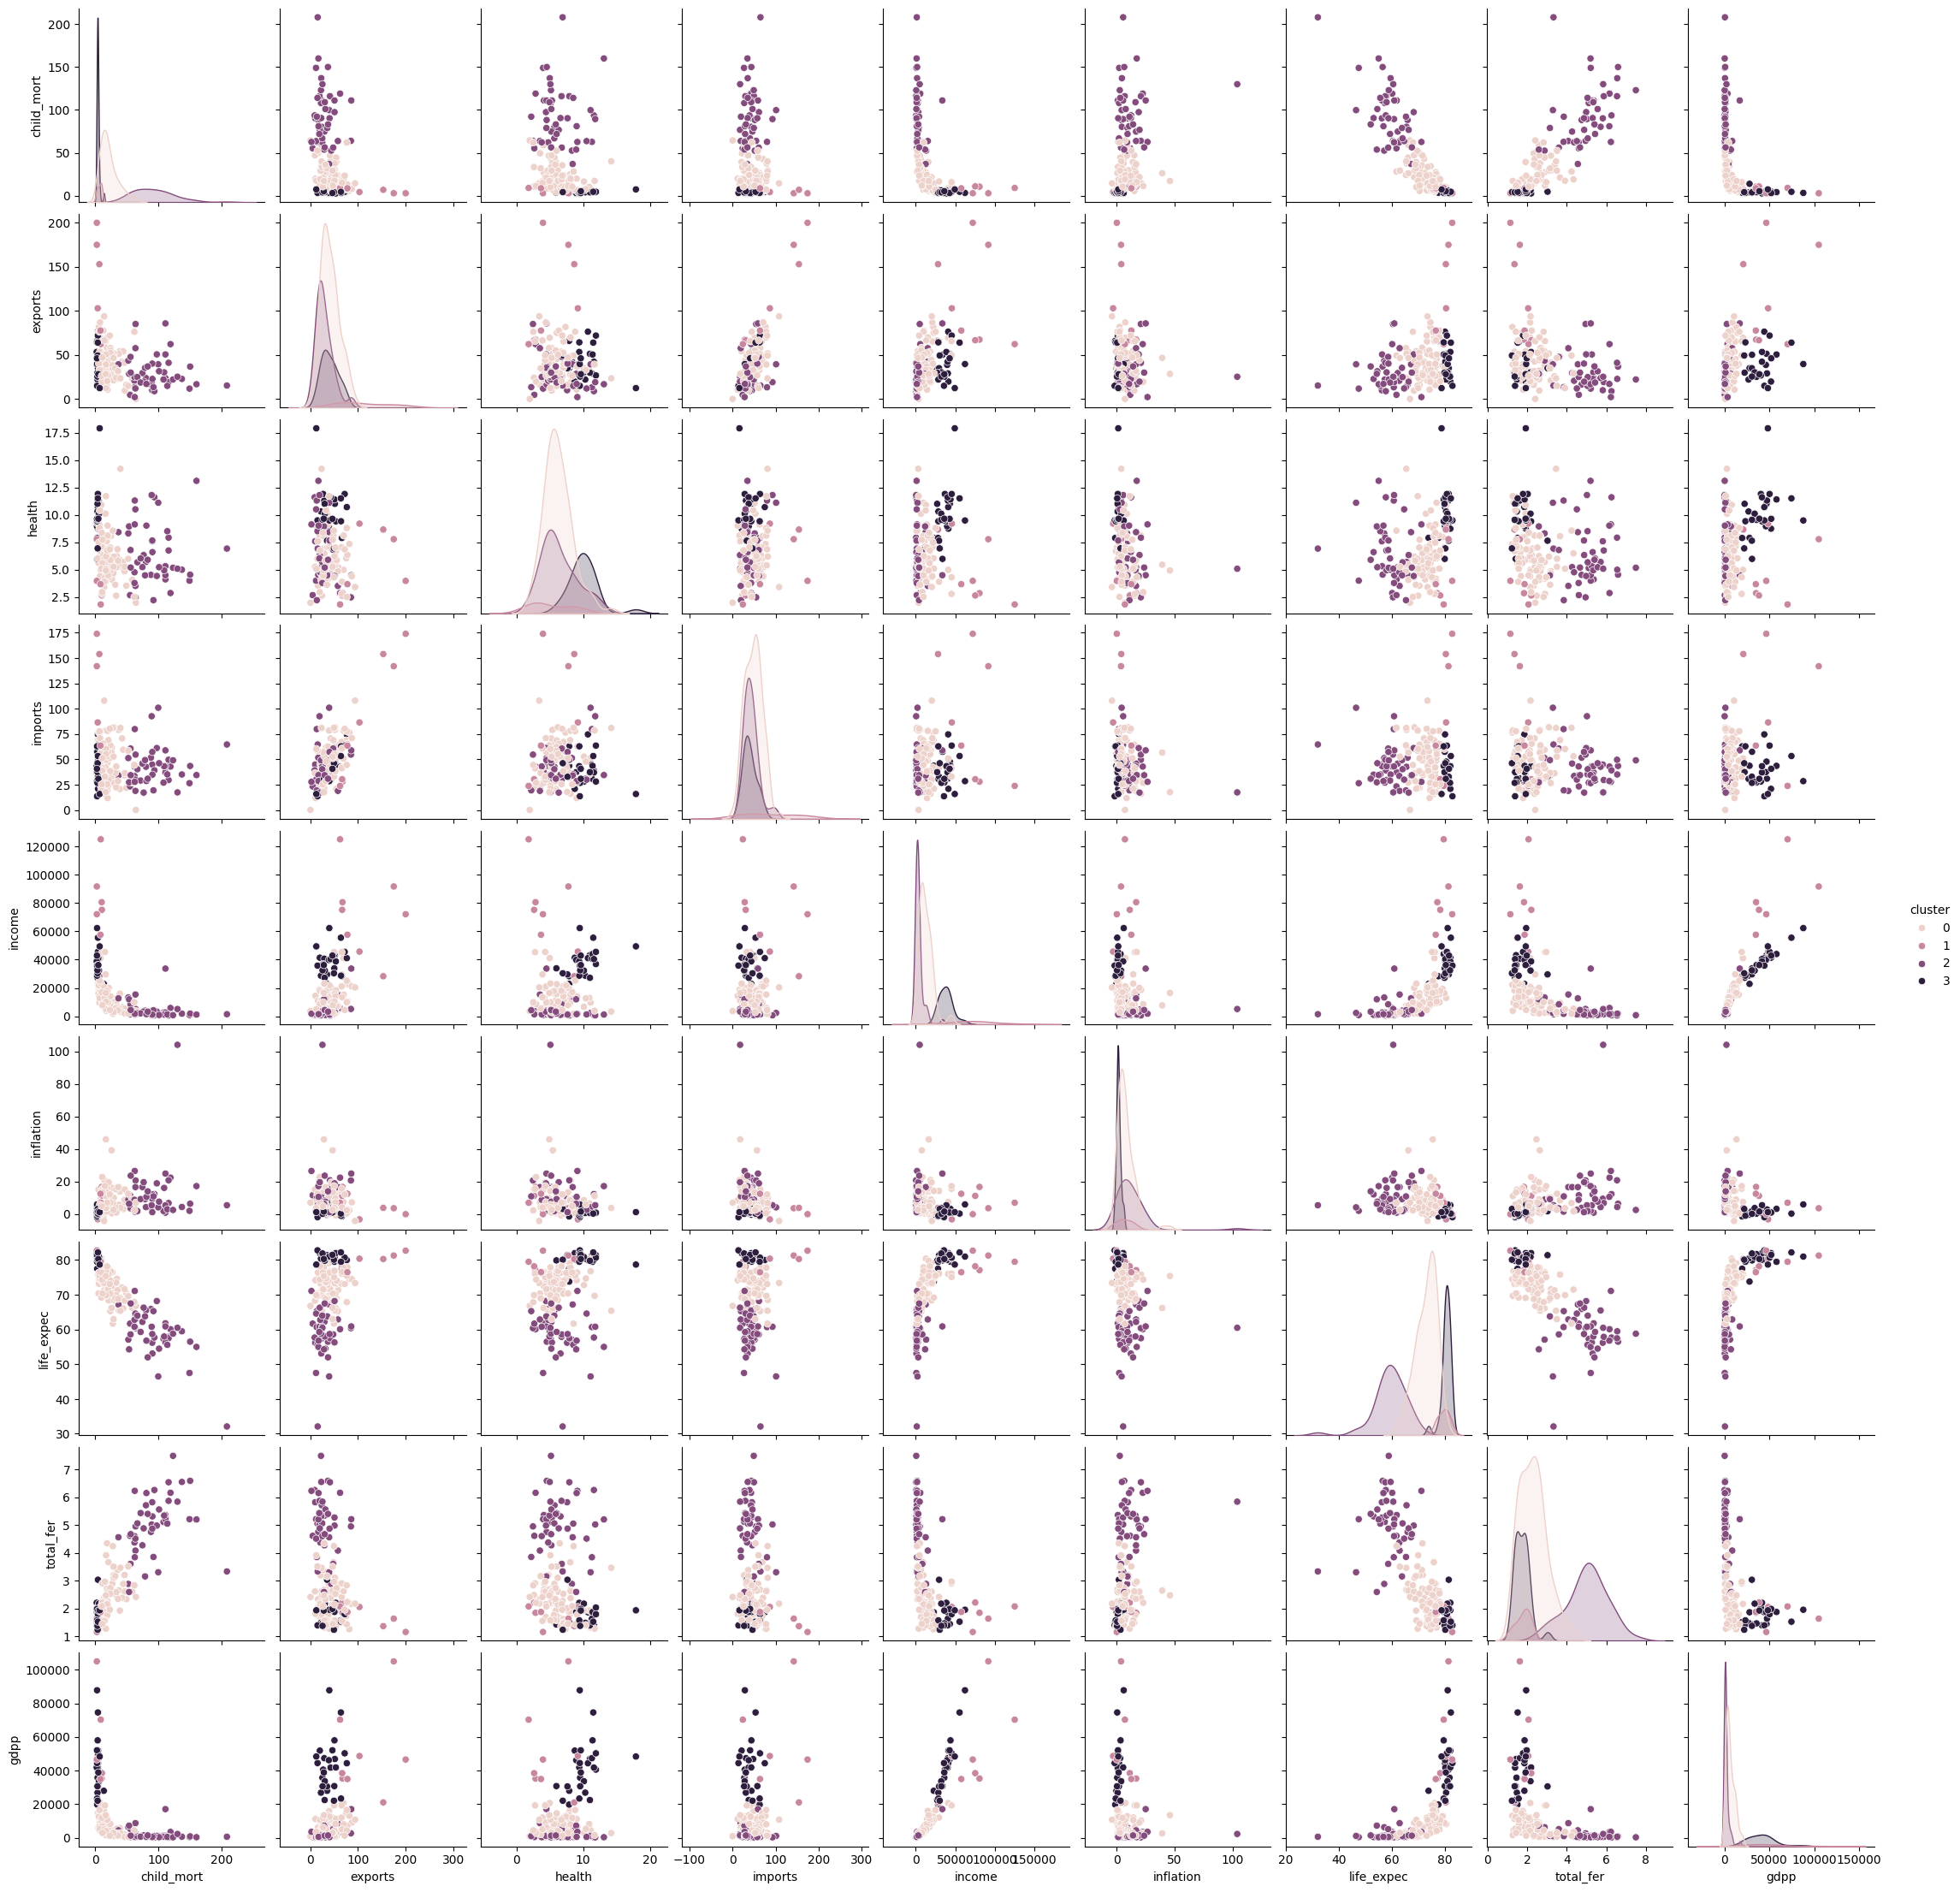

In [138]:
plt.figure()
sns.pairplot(countries.drop(columns=["hc_cluster", "dbscan_cluster"]), hue="cluster")